# Doing Data Science: chapter 2 - EDA

Python code for the exercise on **E**ploratory **D**ata **A**nalysis, 2nd chapter of [Doing Data Science](http://shop.oreilly.com/product/0636920028529.do)

Get input data files from https://github.com/oreillymedia/doing_data_science or http://stat.columbia.edu/~rachel/nytN.csv where `N=[1, .., 31]`.

**Author**: Damien Garaud

**Project on Github**: https://github.com/garaud/doing_pydata_science

## Table of Contents

* [Retrieve Some Data](#Retrieve-Some-Data)
* [Extract Data with pandas](#Extract-Data-with-pandas)
* [Clean up some Data](#Clean-up-some-Data)
* [Categorize by Age](#Categorize-by-Age)
* [Click-through-rate aka CTR by age categories](#Click-through-rate-aka-CTR-by-age-categories)
* [New Category based on the Click Behavior](#New-Category-based-on-the-Click-Behavior)
* [CTR Timeseries](#CTR-Timeseries)

## Retrieve Some Data

Quoting:

> Each file represents one (simulated) day's worth of ads shown and clicks recorded on the NY Times home page in May 2012

You have a script `down_nyt.py` script which can download all `*.csv` file into the `nyt-data` directory.

In [1]:
%matplotlib inline

In [3]:
from io import StringIO

In [4]:
import requests

In [5]:
URL = 'http://stat.columbia.edu/~rachel/datasets/nyt1.csv'

In [46]:
#resp = requests.get(URL)

Save it to a CSV file.

In [47]:
#with open('nyt-data/nyt1.csv', 'bw') as fid:
#    fid.write(resp.content)

In [6]:
!ls nyt-data/*.csv

nyt-data/nyt1.csv  nyt-data/nyt4.csv  nyt-data/nyt7.csv
nyt-data/nyt2.csv  nyt-data/nyt5.csv  nyt-data/nyt8.csv
nyt-data/nyt3.csv  nyt-data/nyt6.csv  nyt-data/nyt9.csv


In [7]:
!head nyt-data/nyt1.csv

"Age","Gender","Impressions","Clicks","Signed_In"
36,0,3,0,1
73,1,3,0,1
30,0,3,0,1
49,1,3,0,1
47,1,11,0,1
47,0,11,1,1
0,0,7,1,0
46,0,5,0,1
16,0,3,0,1


## Extract Data with pandas

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
print("pandas version {}".format(pd.__version__))

pandas version 0.20.3


For a matplotlib version >= 1.4, you can use `plt.style.use("ggplot")`

In [ ]:
# plt.style.use("ggplot")
# pd.options.display.mpl_style = "default"

In [6]:
# Read the file or the 'content'
#df = pd.read_csv(StringIO(resp.content))
df = pd.read_csv("nyt-data/nyt1.csv")

In [7]:
df.head()

,Age,Gender,Impressions,Clicks,Signed_In
0,36,0,3,0,1
1,73,1,3,0,1
2,30,0,3,0,1
3,49,1,3,0,1
4,47,1,11,0,1


## Clean up some Data

The book tells you that `female=0` and `male=1`. I turn these integer values into strings.

In [8]:
df['Gender'].apply(lambda x: 'male' if x else 'female').head()

0    female
1      male
2    female
3      male
4      male
Name: Gender, dtype: object

I overwrite these values into the existing `Gender` column.

In [9]:
df['Gender'] = df['Gender'].apply(lambda x: 'male' if x else 'female')

In [10]:
df.head(10)

,Age,Gender,Impressions,Clicks,Signed_In
0,36,female,3,0,1
1,73,male,3,0,1
2,30,female,3,0,1
3,49,male,3,0,1
4,47,male,11,0,1
5,47,female,11,1,1
6,0,female,7,1,0
7,46,female,5,0,1
8,16,female,3,0,1
9,52,female,4,0,1


## Categorize by Age

Want to categorize by age `<18, 18-24, 25-34, 35-44, 45-54, 55-64, +65`.

Create bins and labels and use `pd.cut` with `right=False` to not include rightmost edge.

In [11]:
age_range = [0, 19, 25, 35, 45, 55, 65, np.inf]
age_labels = ['18--', '18-24', '25-34', '35-44', '45-54', '55-64', '65++']

In [12]:
pd.cut(df['Age'], bins=age_range, right=False, labels=age_labels)

0         35-44
1          65++
2         25-34
3         45-54
4         45-54
5         45-54
6          18--
7         45-54
8          18--
9         45-54
10         18--
11        18-24
12         18--
13        55-64
14        25-34
15         18--
16        35-44
17        25-34
18        35-44
19         18--
20        55-64
21        55-64
22        45-54
23        25-34
24         18--
25        18-24
26        18-24
27        45-54
28        45-54
29        18-24
          ...  
458411    55-64
458412     65++
458413     18--
458414    18-24
458415    35-44
458416    25-34
458417    35-44
458418    55-64
458419    45-54
458420    45-54
458421    45-54
458422    45-54
458423    18-24
458424    18-24
458425    35-44
458426    45-54
458427    35-44
458428    35-44
458429    45-54
458430     18--
458431    18-24
458432    25-34
458433    18-24
458434    55-64
458435    45-54
458436     18--
458437     18--
458438     65++
458439     18--
458440     18--
Name: Age, Length: 45844

Put this into a new columns.

In [13]:
df['Age_group'] = pd.cut(df['Age'], bins=age_range, right=False, labels=age_labels)

In [14]:
df.head(10)

,Age,Gender,Impressions,Clicks,Signed_In,Age_group
0,36,female,3,0,1,35-44
1,73,male,3,0,1,65++
2,30,female,3,0,1,25-34
3,49,male,3,0,1,45-54
4,47,male,11,0,1,45-54
5,47,female,11,1,1,45-54
6,0,female,7,1,0,18--
7,46,female,5,0,1,45-54
8,16,female,3,0,1,18--
9,52,female,4,0,1,45-54


## Click-through-rate aka CTR by age categories

Impressions and click-rate distributions according to this age category.

Let's group data by this `Age_group` just for the impressions and clicks columns and count the number of each.

Simple use the `groupby` function to the column `Age_group`.

In [15]:
df.groupby('Age_group')[['Impressions', 'Clicks']].sum()

,Impressions,Clicks
Age_group,,
18--,781723,22003
18-24,176584,1709
25-34,290511,2937
35-44,355824,3662
45-54,322109,3232
55-64,224688,4556
65++,144120,4350


Here we are ! I count the number of values for each category for the two columns. Compute the CTR (click-through-rate, i.e. `clicks/impression`) and let's plot some stuff.

Some stats about age population categorizes by the age group.

In [16]:
df.groupby('Age_group')['Age'].agg([len,  np.min, np.mean, np.max])

,len,amin,mean,amax
Age_group,,,,
18--,156358,0,1.974168,18
18-24,35270,19,21.269039,24
25-34,58174,25,29.503352,34
35-44,70860,35,39.494680,44
45-54,64288,45,49.492580,54
55-64,44738,55,59.498189,64
65++,28753,65,72.988697,108


I want to store *Impressions* and *Clicks* numbers for each age group.

In [17]:
grouped = df.groupby("Age_group")[['Impressions', 'Clicks']]

In [18]:
df_age_group = grouped.sum()

In [19]:
df_age_group.head()

,Impressions,Clicks
Age_group,,
18--,781723,22003
18-24,176584,1709
25-34,290511,2937
35-44,355824,3662
45-54,322109,3232


You can also call different aggregation functions such as `max`, `mean` or `sum`

In [20]:
age_stat = grouped.agg([len, np.mean, np.max, np.sum])

In [21]:
age_stat

Impressions                         Clicks                      
                  len      mean amax     sum     len      mean amax    sum
Age_group                                                                 
18--           156358  4.999571   18  781723  156358  0.140722    4  22003
18-24           35270  5.006635   17  176584   35270  0.048455    2   1709
25-34           58174  4.993829   17  290511   58174  0.050486    2   2937
35-44           70860  5.021507   20  355824   70860  0.051679    3   3662
45-54           64288  5.010406   17  322109   64288  0.050274    2   3232
55-64           44738  5.022308   16  224688   44738  0.101837    3   4556
65++            28753  5.012347   16  144120   28753  0.151289    3   4350

Compute the click rate.

In [22]:
df_age_group['CTR'] = df_age_group['Clicks'] / df_age_group['Impressions']

Plotting some data.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f487f951400>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f487ea685c0>], dtype=object)

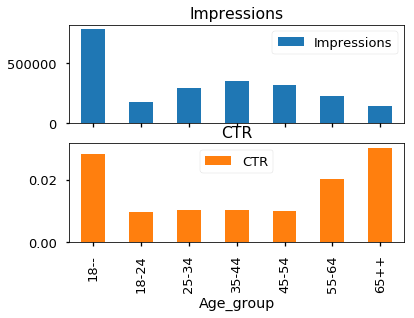

In [23]:
df_age_group[['Impressions', 'CTR']].plot(kind='bar', subplots=True)

## New Category based on the Click Behavior

You can split the population into two new categories:

  - impressions and no click
  - impressions and one or more click(s)
  
You can assume that there isn't click when impression is equal to zero. For that, you can just drop all rows where `Impressions` is 0. Group by 'Clicks' and see what you get.

Drop rows according to `Impresssions` values.

In [24]:
mask_imp = df['Impressions'] > 0

In [25]:
mask_imp.shape

(458441,)

In [26]:
df = df[mask_imp]

In [27]:
df.shape

(455375, 6)

In [28]:
print("Drop {} values".format(mask_imp.shape[0] - df.shape[0]))

Drop 3066 values


Group by **Clicks**.

In [29]:
click_group = df.groupby('Clicks')

Check the number of different Clicks values.

In [30]:
click_group.groups.keys()

dict_keys([0, 1, 2, 3, 4])

OK, you can see, sometimes, there is one more than one click.

You can count the number of elements in each group.

In [31]:
click_group["Gender"].count()

Clicks
0    415537
1     37372
2      2330
3       127
4         9
Name: Gender, dtype: int64

Here, I counted the number of elements for the column "Gender". It's quite arbitrary because you have the same values for each column.

Add a column `has_click` and set `True` if there is more than one click, `False` otherwise.

In [33]:
df.loc[:, 'has_click'] = df['Clicks'] > 0

/home/dag/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [34]:
df.head()

,Age,Gender,Impressions,Clicks,Signed_In,Age_group,has_click
0,36,female,3,0,1,35-44,False
1,73,male,3,0,1,65++,False
2,30,female,3,0,1,25-34,False
3,49,male,3,0,1,45-54,False
4,47,male,11,0,1,45-54,False


You can continue to play with `groupby` with one label or multiple labels.

Maybe you want to know the "click" behavior according to the gender AND the Age category

In [35]:
click_gender_age_grp = df.groupby(['has_click', 'Gender', 'Age_group'])[["Impressions", "Clicks"]].sum().unstack()

In [36]:
click_gender_age_grp

Impressions                                                \
Age_group               18--  18-24   25-34   35-44   45-54   55-64   65++   
has_click Gender                                                             
False     female      609712  77711  128230  156280  142708   92237  76350   
          male         52701  88788  145248  177955  160547  106503  43261   
True      female      110254   4663    8062   10044    8942   11983  15606   
          male          9056   5422    8971   11545    9912   13965   8903   

                 Clicks                                      
Age_group          18-- 18-24 25-34 35-44 45-54 55-64  65++  
has_click Gender                                             
False     female      0     0     0     0     0     0     0  
          male        0     0     0     0     0     0     0  
True      female  20368   797  1388  1707  1542  2105  2765  
          male     1635   912  1549  1955  1690  2451  1585

Of course, there no Clicks for the row `has_click=False`.

Keep only `has_click=True` rows and compute the CTR.

In [37]:
ctr_gender_age = click_gender_age_grp.loc[True]["Clicks"] / click_gender_age_grp.loc[True]["Impressions"]

In [38]:
ctr_gender_age

Age_group,18--,18-24,25-34,35-44,45-54,55-64,65++
Gender,,,,,,,
female,0.184737,0.170920,0.172166,0.169952,0.172445,0.175666,0.177175
male,0.180543,0.168204,0.172667,0.169337,0.170500,0.175510,0.178030


CTR values for each age category between male and female are quite similar, higher for the youngest one and lower for the age group `35-44`.

In [39]:
ctr_gender_age_max = np.max(ctr_gender_age.values)
print('Max CTR value {}'.format(ctr_gender_age_max))

Max CTR value 0.1847370616939068


Relative discrepancy with the max value.

In [40]:
(ctr_gender_age_max - ctr_gender_age) / ctr_gender_age_max * 100.

Age_group,18--,18-24,25-34,35-44,45-54,55-64,65++
Gender,,,,,,,
female,0.000000,7.479308,6.804994,8.003186,6.654008,4.910512,4.093178
male,2.270132,8.949718,6.533382,8.336003,7.706444,4.994589,3.630665


## CTR Timeseries

Load every files, i.e. one file by day for a month, and compute the CTR for each day.

In [41]:
import os
from collections import OrderedDict

In [42]:
PATH = 'nyt-data'
BASENAME = "nyt"
EXT = "csv"
DAY_NUMBER = 31
AGE_RANGE = [0, 19, 25, 35, 45, 55, 65, np.inf]
AGE_LABELS = ['18--', '18-24', '25-34', '35-44', '45-54', '55-64', '65++']

In [43]:
def gender_filter(df):
    colname = "Gender"
    df[colname] = df[colname].apply(lambda x: 'male' if x else 'female')
    return df

In [44]:
def add_age_group(df):
    df['Age_group'] = pd.cut(df['Age'], bins=AGE_RANGE,
                             right=False, labels=AGE_LABELS)
    return df

In [45]:
def drop_no_impression_rows(df):
    mask_imp = df['Impressions'] > 0
    return df[mask_imp]

In [46]:
def add_has_click(df):
    df.loc[:, 'has_click'] = df['Clicks'] > 0
    return df

In [47]:
def clean(df):
    df = gender_filter(df)
    df = add_age_group(df)
    df = drop_no_impression_rows(df)
    df = add_has_click(df)
    return df

In [48]:
def get_gender_age_ctr(df):
    grp_col = ['has_click', 'Gender', 'Age_group']
    gender_age_grp = df.groupby(grp_col)[["Impressions", "Clicks"]].sum().unstack()
    return (gender_age_grp.loc[True]["Clicks"] /
            gender_age_grp.loc[True]["Impressions"])

In [49]:
def main():
    """Loop on each file and return a dict of date: dataframe where the dataframe is
    the CTR by gender and by age group.
    """
    result = OrderedDict()
    for idx in range(1, DAY_NUMBER + 1):
        date_name = "may {}".format(idx)
        fname = os.path.join(PATH, BASENAME + str(idx) + "." + EXT)
        df = pd.read_csv(fname)
        df = clean(df)
        result[date_name] = get_gender_age_ctr(df)
    return result

In [50]:
def ctr_age_by_date(d):
    return pd.DataFrame([x.sum() for x in d.values()], index=d.keys())

def ctr_gender_by_date(d):
    return pd.DataFrame([x.sum(axis=1) for x in d.values()], index=d.keys())

In [51]:
result = main()

/home/dag/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/dag/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [52]:
import pickle

In [53]:
pickle.dump(result, open("result.pkl", "bw"), -1)

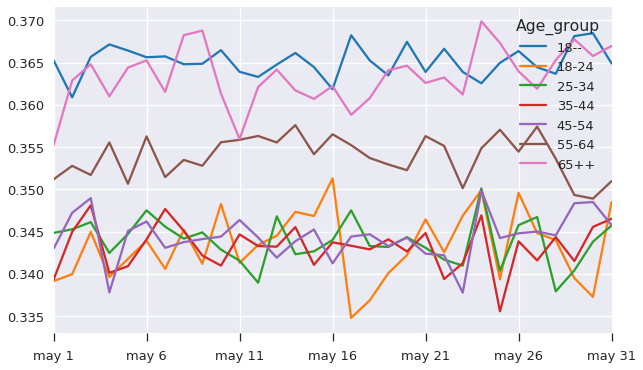

In [59]:
with sns.axes_style("darkgrid", {'xtick.major.size': 8.0}):
    fig, ax = plt.subplots(figsize=(10,6))
    ctr_age_by_date(result).plot(ax=ax)

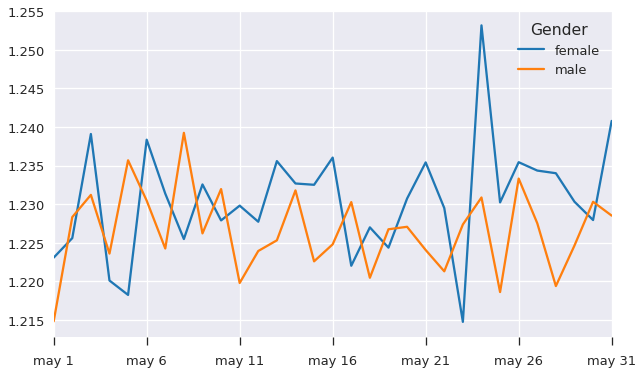

In [61]:
with sns.axes_style("darkgrid", {'xtick.major.size': 8.0}):
    fig, ax = plt.subplots(figsize=(10,6))
    ctr_gender_by_date(result).plot(ax=ax)

<h3 style="text-align: center;"><a href="#Doing-Data-Science:-chapter-2---EDA">Back to Top</a></h3>